In [102]:
# import libraries needed
import IPython
import pandas as pd
import numpy as np
from statistics import mode
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# load original data into dataframe and check shape
df_ori = pd.read_excel("C:/Arshi/Hackathon 2018/DataSet/problem3_readmission_diabetic.xlsx")
print(df_ori.shape)
# examine the data types and descriptive stats
print(df_ori.info())
print(df_ori.describe())
# make a copy of the dataframe for preprocessing
df = df_ori.copy(deep=True)

(101766, 48)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 48 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101766 non-null object
diag_2               

In [8]:
def outliers(x): 
    return np.abs(x- x.median()) > 1.5*(x.quantile(.75)-x.quantile(0.25))

In [13]:
df.time_in_hospital[outliers(df.time_in_hospital)]

8         13
9         12
15        12
23        11
42        13
49        11
71        12
73        14
114       14
121       11
123       11
135       13
144       11
151       14
175       11
180       13
185       12
209       12
237       11
248       14
251       11
255       11
280       14
285       12
310       13
323       12
325       13
336       12
337       12
363       11
          ..
100980    11
101094    11
101128    13
101144    11
101147    11
101163    14
101228    14
101291    11
101306    12
101324    14
101353    11
101378    11
101417    12
101449    13
101458    14
101476    11
101488    11
101526    13
101540    11
101548    13
101587    12
101618    11
101631    14
101649    11
101715    13
101725    12
101748    14
101751    13
101753    13
101755    14
Name: time_in_hospital, Length: 5555, dtype: int64

In [103]:
for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())

race 2273
gender 0
age 0
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


In [104]:
# gender was coded differently so we use a custom count for this one
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count())

gender 3


In [105]:
df = df.drop(['medical_specialty'], axis = 1)

In [106]:
drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)
drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 11].index))
new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]

In [107]:
df = df.drop(['citoglipton', 'examide'], axis = 1)

In [108]:
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

In [109]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]

In [110]:
df['numchange'].value_counts()

0    72868
1    25832
2     1308
3      107
4        5
Name: numchange, dtype: int64

In [111]:
df['nummed'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No') else 1)
for col in keys:
    colname = str(col) + 'temp'
    df['nummed'] = df['nummed'] + df[colname]
    del df[colname]

In [112]:
df['nummed'].value_counts()

1    46438
0    22844
2    21712
3     7738
4     1325
5       58
6        5
Name: nummed, dtype: int64

In [113]:
# create a duplicate of the diagnosis column
df['level1_diag1'] = df['diag_1']
# disease codes starting with V or E are in “other” category; so recode them to 0
df.loc[df['diag_1'].str.contains('V', na=False), ['level1_diag1']] = 0
df.loc[df['diag_1'].str.contains('E', na=False), ['level1_diag1']] = 0
# also replace the unknown values with -1
df['level1_diag1'] = df['level1_diag1'].replace('?', -1)
# iterate and recode disease codes between certain ranges to certain categories
for index, row in df.iterrows():
    if (row['level1_diag1'] >= 390 and row['level1_diag1'] < 460) or (np.floor(row['level1_diag1']) == 785):
        df.loc[index, 'level1_diag1'] = 1
    elif (row['level1_diag1'] >= 460 and row['level1_diag1'] < 520) or (np.floor(row['level1_diag1']) == 786):
        df.loc[index, 'level1_diag1'] = 2
    elif (row['level1_diag1'] >= 520 and row['level1_diag1'] < 580) or (np.floor(row['level1_diag1']) == 787):
        df.loc[index, 'level1_diag1'] = 3
    elif (np.floor(row['level1_diag1']) == 250):
        df.loc[index, 'level1_diag1'] = 4
    elif (row['level1_diag1'] >= 800 and row['level1_diag1'] < 1000):
        df.loc[index, 'level1_diag1'] = 5
    elif (row['level1_diag1'] >= 710 and row['level1_diag1'] < 740):
        df.loc[index, 'level1_diag1'] = 6
    elif (row['level1_diag1'] >= 580 and row['level1_diag1'] < 630) or (np.floor(row['level1_diag1']) == 788):
        df.loc[index, 'level1_diag1'] = 7
    elif (row['level1_diag1'] >= 140 and row['level1_diag1'] < 240):
        df.loc[index, 'level1_diag1'] = 8
    else:
        df.loc[index, 'level1_diag1'] = 0
# convert this variable to float type to enable computations later
df['level1_diag1'] = df['level1_diag1'].astype(float)

In [114]:
df[['diag_1','level1_diag1']].head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
diag_1,250.83,276,648,8,197,414,414,428,398,434,250.7,157,428,428,518
level1_diag1,4,0,0,0,8,1,1,1,1,1,4,8,1,1,2


In [115]:
df.to_csv("C:/Arshi/Hackathon 2018/DataSet/problem3_readmission_diabetic_Filtered1.csv")

In [116]:
df['admission_type_id'] = df['admission_type_id'].replace(2,1)
df['admission_type_id'] = df['admission_type_id'].replace(7,1)
df['admission_type_id'] = df['admission_type_id'].replace(6,5)
df['admission_type_id'] = df['admission_type_id'].replace(8,5)

In [117]:
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)
# keys is the same as before
for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)

In [118]:
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
df['A1Cresult'] = df['A1Cresult'].replace('None', -99)
df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)

In [119]:
df['readmitted'] = df['readmitted'].replace('>30', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)

In [120]:
age_dict = {'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35, '[40-50)':45, '[50-60)':55, '[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95}
df['age'] = df.age.map(age_dict)
df['age'] = df['age'].astype('int64')
print(df.age.value_counts())

75    25564
65    22186
55    17102
85    16708
45     9626
35     3765
95     2669
25     1650
15      690
5       160
Name: age, dtype: int64


In [128]:
df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df.shape

(70442, 49)

In [129]:
numerics = ["admission_type_id", "age","discharge_disposition_id", "admission_source_id", "time_in_hospital","num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses", "change", "diabetesMed", "readmitted", "service_utilization", "numchange", "nummed", "level1_diag1"]
numerics.extend(keys)

In [130]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

# numerics is a list of all numeric features
df[numerics] = standardize(df[numerics])

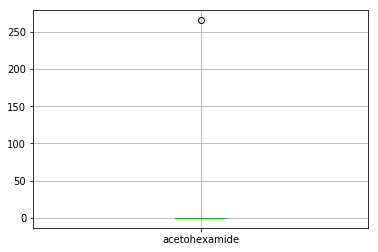

In [134]:
import scipy.stats as sp
import warnings

df.boxplot(column='acetohexamide')


In [132]:
df2 = df2[(np.abs(sp.stats.zscore(df2[numerics])) < 3).all(axis=1)]

C:\Users\AK045801\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:2247: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis)
C:\Users\AK045801\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\AK045801\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\AK045801\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\AK045801\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [137]:
# increase row display limit
pd.options.display.max_rows = 400
# calculate correlation matrix and store as absolute values
c = df.corr().abs()
# unstake the table
s = c.unstack()
# sort the values in descending order
so = s.sort_values(ascending=False)
# display the most relevant part of the list
so[38:120]

max_glu_serum        max_glu_serum          1.000000
A1Cresult            A1Cresult              1.000000
metformin            metformin              1.000000
repaglinide          repaglinide            1.000000
numchange            numchange              1.000000
encounter_id         encounter_id           1.000000
number_outpatient    service_utilization    0.808302
service_utilization  number_outpatient      0.808302
nummed               change                 0.731185
change               nummed                 0.731185
diabetesMed          nummed                 0.706872
nummed               diabetesMed            0.706872
change               numchange              0.609089
numchange            change                 0.609089
diabetesMed          insulin                0.572456
insulin              diabetesMed            0.572456
nummed               metformin              0.548881
metformin            nummed                 0.548881
service_utilization  number_inpatient       0.

In [139]:
interactionterms = [('num_medications','time_in_hospital'), ('num_medications','num_procedures'), ('time_in_hospital','num_lab_procedures'),
('num_medications','num_lab_procedures'), ('num_medications','number_diagnoses'),
('age','number_diagnoses'), ('change','num_medications'), ('number_diagnoses','time_in_hospital'), ('num_medications','numchange')]
 
for inter in interactionterms:
    name = inter[0] + '|' + inter[1]
    df[name] = df[inter[0]] * df[inter[1]]

In [204]:
training_features = ["age","discharge_disposition_id", "admission_source_id", "time_in_hospital","num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses", "change", "diabetesMed", "readmitted", "service_utilization", "numchange", "nummed", "level1_diag1"]
for feature in training_features:
    df = df[pd.notnull(df[feature])]
df.to_csv("C:/Arshi/Hackathon 2018/DataSet/problem3_readmission_diabetic_Filtered_Step141.csv")

In [205]:
from sklearn.model_selection import train_test_split 

# load original data into dataframe and check shape
df_ori = pd.read_csv('C:/Arshi/Hackathon 2018/DataSet/problem3_readmission_diabetic_Filtered_Step141.csv')


train, test = train_test_split(df_ori, test_size=0.3)

In [206]:
train_output = df_ori['readmitted']

In [207]:
train_input = df_ori[training_features]

In [210]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(train_output)))
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(train_input, train_output.astype('int'))
print('New dataset shape {}'.format(Counter(train_output_new)))

Original dataset shape Counter({-0.31329074805932955: 64146, 3.191923177416416: 6296})
New dataset shape Counter({0: 64146, 3: 64146})


In [213]:
from sklearn.tree import DecisionTreeClassifier
dte = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
print("Cross Validation score: {:.2%}".format(np.mean(cross_val_score(dte, X_train, Y_train, cv=10))))
dte.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(dte.score(X_dev, Y_dev)))

Cross Validation score: 100.00%
Dev Set score: 100.00%


In [217]:
Y_dev_predict = dte.predict(X_dev)
pd.crosstab(pd.Series(Y_dev, name = 'Actual'), pd.Series(Y_dev_predict, name = 'Predict'), margins = True)
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print("Accuracy is {0:.2f}".format(accuracy_score(Y_dev, Y_dev_predict)))


Accuracy is 1.00
